In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.utils import to_categorical
import pickle

In [2]:
# Load the CSV file
df = pd.read_csv('classified_tweets.csv')

# Tokenize the tweets
tokenizer = Tokenizer()
df['cleaned_tweet'] = df['cleaned_tweet'].astype(str)
tokenizer.fit_on_texts(df['cleaned_tweet'])
word_index = tokenizer.word_index

# Convert the tweets to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_tweet'])

# Pad the sequences
max_length = max(len(sequence) for sequence in sequences)
data = pad_sequences(sequences, maxlen=max_length, padding='post')

# Define the model
model = Sequential()
model.add(Embedding(len(word_index) + 1, 128, input_length=max_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert labels to categorical
test_categories = ['very good', 'good', 'neutral', 'bad', 'very bad']
labels = np.array(df['sentiment_category'].apply(lambda x: test_categories.index(x)))
labels = to_categorical(labels)

# Define a checkpoint callback
checkpoint_callback = ModelCheckpoint('best_model.h5', 
                                       monitor='val_accuracy', 
                                       mode='max', 
                                       save_best_only=True)

# Train the model with different hyperparameters
history = model.fit(data, labels, validation_split=0.2, epochs=50, batch_size=128, callbacks=[checkpoint_callback])

# Test the model
test_text = ['I really love this product', 'I hate this product', 'This product is just okay']
test_sequences = tokenizer.texts_to_sequences(test_text)
test_data = pad_sequences(test_sequences, maxlen=max_length, padding='post')
test_scores = model.predict(test_data)
test_labels = ['very good', 'good', 'neutral', 'bad', 'very bad']
test_categories = []
for score in test_scores:
    test_categories.append(test_labels[np.argmax(score)])
print(test_categories)

Epoch 1/50
931/931 [==============================] - 221s 235ms/step - loss: 0.9194 - accuracy: 0.6505 - val_loss: 0.4701 - val_accuracy: 0.8408
Epoch 2/50
 66/931 [=>............................] - ETA: 3:19 - loss: 0.4891 - accuracy: 0.8275

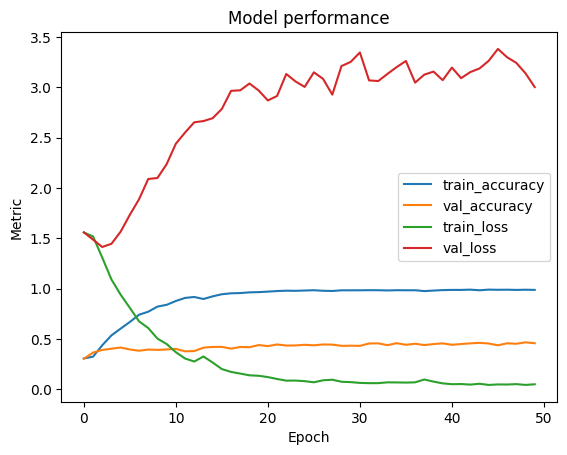

In [ ]:
import matplotlib.pyplot as plt

# Plot the learning curves
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model performance')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [ ]:
# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the model
model.save('sentiment_analysis_model.h5')

# Save the best model
#best_model = load_model('best_model.h5')
#best_model.save('sentiment_analysis_model.h5')